# Adopting Geometric Stoichiometry to PISCES

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
ncf_ptrc= "printy2_1y_ptrc_Y1028.nc"
ncf_diad= "printy2_1y_diad_Y1028.nc"

ptrc= xr.open_dataset(ncf_ptrc)
diad= xr.open_dataset(ncf_diad)

In [3]:
## Parameter from Geometric Stoichiometry
xi0  = 0.052   # other basal metabolism (day -1)
eta  = 0.1    # SDA (dimensionless)
betaV = 0.64  # protein absorption efficiency (dimensionless)
betaH = 0.64  # carbs absorption efficiency (dimensionless)
kstarN = 0.9  # max N synthesis efficiency (dimensionless)
thetaZ = 5.5  # C:N of zoo (molC/molN)
thetaV = 3.7  # C:N of protein (molC/molN)
phi    = 0.5  # penalty (dimensionless)
fV     = 0.5  # allocation to protein (dimensionless)

## parameter from PISCES
no3rat3 = 0.151     # N:C ratio in zoplankton
epsher= 0.5         # growth efficiency - Can this be max C synthesis efficiency?
epsherN= 0.0755     # epsher*no3rat3
thetaZP = 1/no3rat3 # Zoo C:N ratio from PISCES
unassc= 0.3         # Unassimilated C
unassn= 0.3         # Unassimilated N
sigma= 0.5          # Fraction excreted as semi-labile DOM

betaV= 0.7
betaH= 0.7
thetaZP= 1/no3rat3

meso= ptrc['ZOO2'].isel(deptht=0)

xi1= xi0*meso




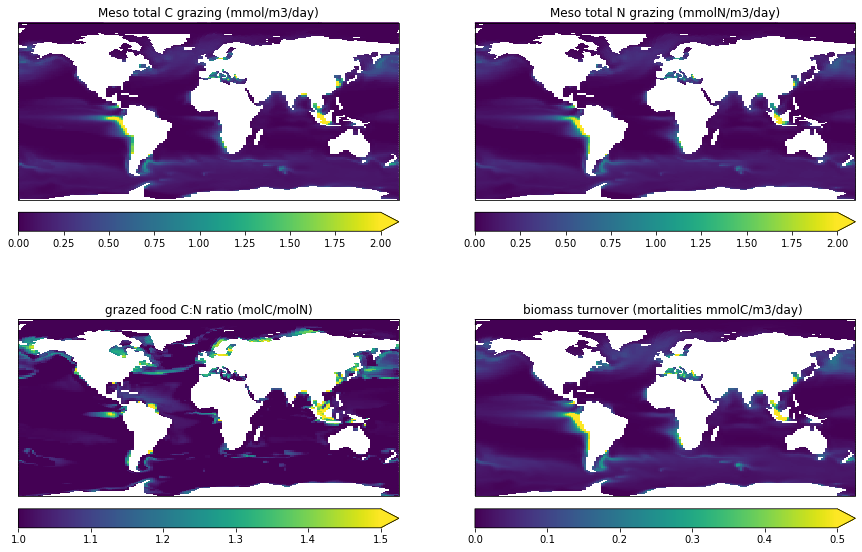

In [4]:
# extract zooplankton grazing on C
g_meso= diad['GRAZ2'].isel(deptht=0) *86400 * 1000

# extract zooplankton grazing on N
gn_meso= diad['GRAZN2'].isel(deptht=0) *86400 * 1000

# extract mortalities (for turnover rate?)
mortme= diad['TAUZ2'].isel(deptht=0) *86400 * 1000
mortmi= diad['TAUZ1'].isel(deptht=0) *86400 * 1000

fig= plt.figure(figsize=(15,10))
ax0= plt.subplot(2,2,1, projection= ccrs.PlateCarree())
cn_graz=g_meso
ica=cn_graz.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 2, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=False)
ax0.set_title('Meso total C grazing (mmol/m3/day)')
plt.colorbar(ica, orientation="horizontal", pad=0.05, ax=ax0, extend='max')

ax0= plt.subplot(2,2,2, projection= ccrs.PlateCarree())
cn_graz=gn_meso
INa=cn_graz.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 2, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=False)
ax0.set_title('Meso total N grazing (mmolN/m3/day)')
plt.colorbar(INa, orientation="horizontal", pad=0.05, ax=ax0, extend='max')

ax0= plt.subplot(2,2,3, projection= ccrs.PlateCarree())
cn_graz= g_meso/gn_meso
cna=cn_graz.plot(y='nav_lat', x='nav_lon', vmin=1, vmax= 1.5, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=False)
ax0.set_title('grazed food C:N ratio (molC/molN)')
plt.colorbar(cna, orientation="horizontal", pad=0.05, ax=ax0, extend='max')

ax0= plt.subplot(2,2,4, projection= ccrs.PlateCarree())
taua= mortme.plot(y='nav_lat', x='nav_lon', vmin=0, vmax=0.5, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=False)
ax0.set_title('biomass turnover (mortalities mmolC/m3/day) ')
plt.colorbar(taua, orientation="horizontal", pad=0.05, ax=ax0, extend='max')


**Step.0** calculating intake of protein and carbohydrate

We can derive intakes of protein (IV) and carbohydrate (IH) from zooplankton grazing on carbon (mmolC m$^{-3}$ day$^{-1}$):
\begin{align}
I_V &= \frac{\theta_V G_C}{\theta_{G_C}} \\
I_H &= \frac{(\theta_V - \theta_{G_C}) G_C} {\theta_{G_C}}
\end{align}

Where $G_C$ and $\theta_{G_C}$ are the total C grazing and C:N ratio of total grazing. This makes our IV and IH units in mmol C m$^{-3}$ day$^{-1}$

Text(0.5, 1.0, 'Carbohydrate from grazed food mmolC/m3/day')

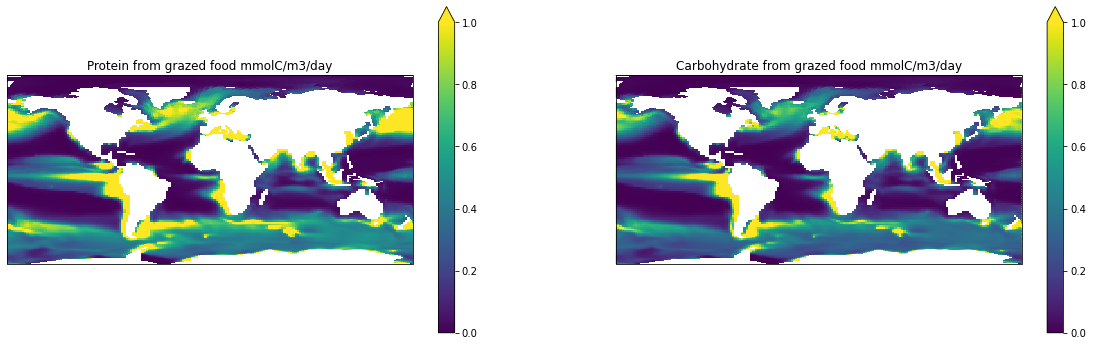

In [5]:
protein= (thetaV/cn_graz)*g_meso
carbo= (thetaV-cn_graz)/cn_graz*g_meso  

fig= plt.figure(figsize=(20,6))
ax0= plt.subplot(1,2,1, projection= ccrs.PlateCarree())
protein.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 1, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title(r'Protein from grazed food mmolC/m3/day')

ax0= plt.subplot(1,2,2, projection= ccrs.PlateCarree())
carbo.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 1, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title(r'Carbohydrate from grazed food mmolC/m3/day')


**Step 1.**
Utilisation of Carbohydrate. 

Optimum nutrition protein:carbohydrate ratio is met when the energetic requirements are met using carbohydrate and still have protein to spare for growth with maximum efficiency. C is in excess when intake of carbohydate exceeds the optimum ratio 

First we calculate the excess C, which can be deducted from the carbohydrate requirements associated with maintenance and growth, with Threshold Elemental Ratio (TER). 

Protein intake that is required to meet the cost of biomass turnover ($\tau$), I$_\text{Vm}$:
\begin{equation}
I_{Vm}= \frac{\theta_V \tau}{\beta_V K^\star_N \theta_Z}
\end{equation}
Here, I use quadratic + linear mortalities as $\tau$ - thus having a unit of mmol C m$^{-3}$ day$^{-1}$.
The additional C required to make up the demand for C for the replacement of new biomass (turnover), D$_\text{Xm}$ is:
\begin{equation}
D_{Xm}=\frac{(\theta_Z - \theta_V)\tau}{\theta_Z}
\end{equation}

If carbohydrate can solely met D$_\text{Xm}$, the required carbohydrate intake, taking into account losses to absorption and SDA, I$^{\star}_{Hm}$ is:
\begin{equation}
I^\star_{Hm}=\frac{\eta I_{Vm} + D_{Xm} + \xi}{\beta_{H} - \eta}
\end{equation}

for each unit of carbohydrate intake, only fraction $\beta_H-\eta$ is available due to losses associated with absorption and SDA.

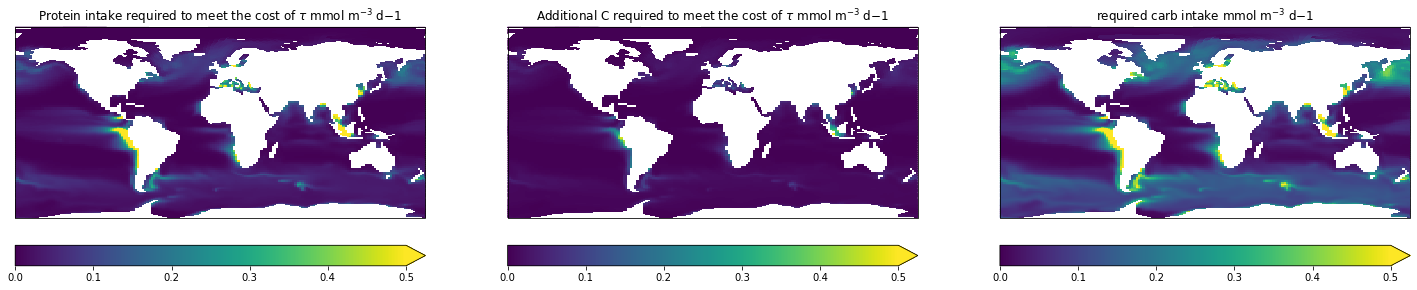

In [6]:
#Protein intake that is required to meet the cost of biomass turnove
I_vm= thetaV*mortme/(betaV*kstarN*thetaZ)

#additional C required to make up the demand for C 
#for the replacement of new biomass (turnover),
Dx_m = (thetaZ - thetaV)*mortme/thetaZ

#required Carb intake + metabolism and SDA:
IstrHM= ((eta*I_vm)+Dx_m+xi1)/(betaH - eta)

fig= plt.figure(figsize=(25,10))
ax0= plt.subplot(1,3,1, projection= ccrs.PlateCarree())
ivm= I_vm.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.5, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=False)
ax0.set_title(r'Protein intake required to meet the cost of $\tau$ mmol m$^{-3}$ d${-1}$' )
plt.colorbar(ivm, orientation="horizontal", pad=0.05, ax=ax0, extend='max')

ax0= plt.subplot(1,3,2, projection= ccrs.PlateCarree())
Dx_m.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.5, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=False)
ax0.set_title(r'Additional C required to meet the cost of $\tau$ mmol m$^{-3}$ d${-1}$')
plt.colorbar(ivm, orientation="horizontal", pad=0.05, ax=ax0, extend='max')

ax0= plt.subplot(1,3,3, projection= ccrs.PlateCarree())
IstrHM.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.5, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=False)
ax0.set_title(r'required carb intake mmol m$^{-3}$ d${-1}$')
plt.colorbar(ivm, orientation="horizontal", pad=0.05, ax=ax0, extend='max')

**Step 1.**
Cont. 

Protein for growth (without maintenance) has the same form as that of maintenance (see equation 1):
    \begin{equation}
    I^n_{VG}= \frac{\theta_V}{\beta_V K^\star_N \theta_Z}
    \end{equation}

Demand for additional C intake of carbohydrate are:
\begin{align}
D^n_{XG} &= (\frac{\theta_Z - \theta_V}{\theta_Z})\\
I^{n \star}_{HG} &= \frac{\eta I^n_{VG} + D^n_{XG}}{\beta_H - \eta}
\end{align}

basal metabolism does not appear in the equation for $I^{n^{\star}}_{HG}$, such that the C:N ratio of maintenance exceeds that of growth and animals require relatively C-rich diets when intake is low (Anderson et al., 2017). The C:N ratio of growth is:
\begin{equation}
\theta^{\star}_{\text{HVG}}= \frac{I^{n \star}_{HG}}{I^n_{VG}}
\end{equation}

<span style="color:red">but the units in here is be dimensionless instead of molC/molN</span>.

In [7]:
IN_vg = thetaV / (betaV*kstarN*thetaZ)
DN_xg = (thetaZ - thetaV)/ thetaZ # demand for additional C intake
INstrhg = ((eta*IN_vg)+DN_xg)/(betaH - eta)

# C:N ratio for growth
thestrhvg= INstrhg/IN_vg
print('C:N ratio for growth=', thestrhvg)


C:N ratio for growth= 0.6774774774774773


We can now calculate the carbohydrate to protein ratio that gives optimal nutrition $\theta^{\star}_{HV}$ (when allocation towards protein (fV) = 0):

\begin{equation}
\theta^{\star}_{HV}= \frac{I^\star_{HM}+(I_V - I_{Vm}) \theta^{\star}_{\text{HVG}} }{I_V}
\end{equation}


<span style="color:red">$\theta^{\star}_{\text{HVG}}$ is unitless, so $\theta^{\star}_{HV}$ is also unitless</span>.

The maximum available carbohydrate corresponding to a given protein intake ($I^\star_H$):
\begin{equation}
I^\star_H= I_V \theta^{\star}_{HV}
\end{equation}
<span style="color:red"> This is in mmol C m-3 day-1 </span>.

If $I_H$ > $I^\star_H$, then carbon is in stoichiometric excess.  The carbohydrate that is allocated to growth and metabolism is thus the minimum of $I_H$ and $I^\star_H$:
\begin{equation}
I_{HU}= \text{min}\left[I_H, I^\star_H\right]
\end{equation}
The excess rate of C intake, Cx is:
\begin{equation}
C_X= (\beta_H - \eta)(I_H - I_{HU})
\end{equation}

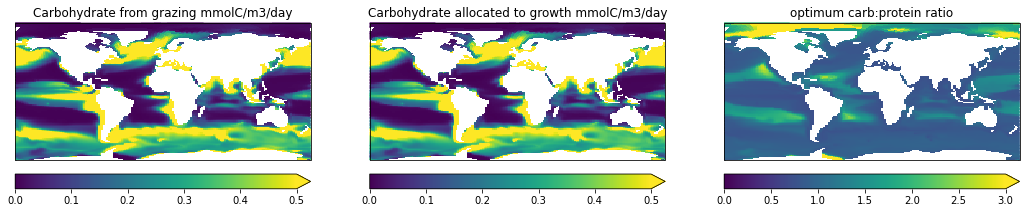

In [8]:
thestarhv= (IstrHM+((protein-I_vm)*thestrhvg))/protein
istarH= protein*thestarhv

IHU= carbo.where((carbo<istarH)| carbo.isnull(), istarH)
IHU2= IHU.where((carbo>istarH)| IHU.isnull(), carbo)

Cx = (betaH - eta)*(carbo - IHU2)

fig= plt.figure(figsize=(18,5))
ax0= plt.subplot(1,3,1, projection= ccrs.PlateCarree())
carb= carbo.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.5, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=False)
ax0.set_title(r'Carbohydrate from grazing mmolC/m3/day')
plt.colorbar(carb, orientation="horizontal", pad=0.05, ax=ax0, extend='max')

# fig= plt.figure(figsize=(18,5))
ax0= plt.subplot(1,3,2, projection= ccrs.PlateCarree())
ihu=IHU2.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.5, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=False)
ax0.set_title(r'Carbohydrate allocated to growth mmolC/m3/day')
plt.colorbar(ihu, orientation="horizontal", pad=0.05, ax=ax0, extend='max')


ax0= plt.subplot(1,3,3, projection= ccrs.PlateCarree())
ratio=thestarhv.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 3, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=False)
ax0.set_title('optimum carb:protein ratio')
plt.colorbar(ratio, orientation="horizontal", pad=0.05, ax=ax0, extend='max')


**Step 2** Calculate allocation towards protein and growth

if intake of carbohydrate is more than sufficient to fully meet metabolic requirements ($I_H$ > $I^\star_{H}$), then fV = 0. Otherwise, fv is calculated by rearrangement of carbohydrate (IH) and protein (IV) in the backward model:
\begin{align}
fv&=\frac{-a+bd-bc}{-a+\phi bd-d-bc}\\
a&= \beta_V I_V\\
b&= \frac{\theta_v}{k^{\star}_N(\theta_z -\theta_v)}\\
c&= \xi + \eta(I_V + I_{HU})\\
d&= \beta_H I_{HU}
\end{align}

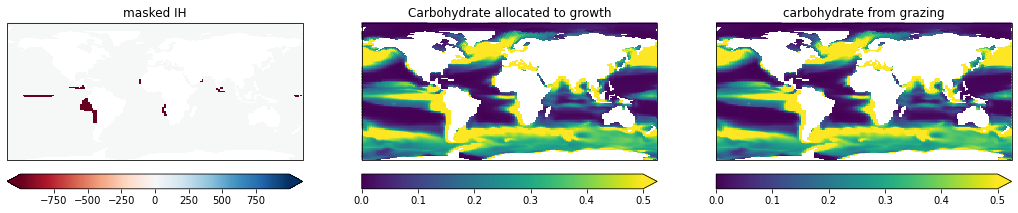

In [9]:
# check where IH is greater than I*H, and ,mask it (fV=0)
difIH= carbo-istarH
masIH= carbo.where((difIH <= 0)| carbo.isnull(), -999)

fig= plt.figure(figsize=(18,5))
ax0= plt.subplot(1,3,1, projection= ccrs.PlateCarree())
ax0m= masIH.plot(y='nav_lat', x='nav_lon', cmap='RdBu', transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=False)
ax0.set_title(r'masked IH')
plt.colorbar(ax0m, orientation="horizontal", pad=0.05, ax=ax0, extend='both')

# fig= plt.figure(figsize=(18,5))
ax0= plt.subplot(1,3,2, projection= ccrs.PlateCarree())
ax0I=IHU2.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.5, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=False)
ax0.set_title(r'Carbohydrate allocated to growth')
plt.colorbar(ax0I, orientation="horizontal", pad=0.05, ax=ax0, extend='max')

ax0= plt.subplot(1,3,3, projection= ccrs.PlateCarree())
ax0c= carbo.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.5, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=False)
ax0.set_title('carbohydrate from grazing')
plt.colorbar(ax0c, orientation="horizontal", pad=0.05, ax=ax0, extend='max')

Text(0.5, 1.0, 'allocation towards protein (fV)')

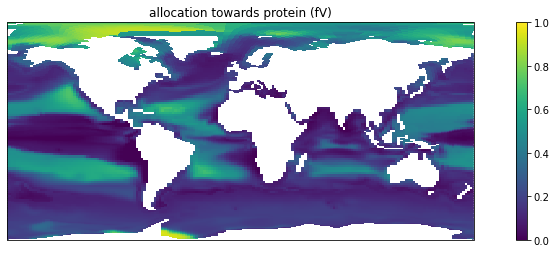

In [10]:
# now calculate areas where IH is smaller than I*H
a = betaV * protein # mmol C m-3 day-1
b = thetaV/(kstarN*(thetaZ-thetaV)) # unitless
c = xi1 + eta*(protein+IHU2) # mmol C m-3 day-1
d = betaH*masIH # mmol C m-3 day-1
fV0 = (-a+(b*d) - (b*c))/(-a + (phi*b*d) - d - (b*c))
fV= fV0.where((fV0 < 10)| fV0.isnull(), 0)


fig= plt.figure(figsize=(15,4))
ax0= plt.subplot(1,1,1, projection= ccrs.PlateCarree())
fV.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 1.0, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('allocation towards protein (fV)')

Further rearrangement of these equations gives DCX, allowing calculation of growth, G:
\begin{align}
D_{CX}&=\frac{\beta_H I_{HU}(1-\phi fV)}{(1-fV)}-(\xi + \eta(I_V + I_{HU})), fv < 1 ; \\
G &= \frac{\theta_Z D_{CX}}{\theta_z-\theta_V}-\tau, fv < 1; \\
G &= \frac{\beta_V I_V - \frac{\xi + \eta(I_V + I_{HU})}{1-\phi}}{\frac{\theta_V}{K^\star_N \theta_Z}+ \frac{\theta_Z-\theta_V}{(1-\phi)\theta_Z}}- \tau, fv =1 
\end{align}

Text(0.5, 1.0, 'growth mmol C m-3 day-1')

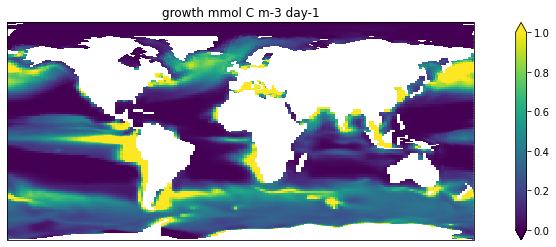

In [11]:
# (betaH*IHU*(1-phi*fV))/(1-fV)-(xi+eta*(IV+IHU))
DCX  = ((betaH*IHU2*(1-phi*fV))/(1-fV))-(xi1+eta*(protein+IHU2)) # mmol C m-3 day-1

# DCX   = DCX0.where((DCX0 > 0)| DCX0.isnull(), 1e-15) # I add 1e-15 to avoid negative numbers

G = ((thetaZ*DCX)/(thetaZ-thetaV)) - mortme # mmol C m-3 day-1

fig= plt.figure(figsize=(15,4))
ax0= plt.subplot(1,1,1, projection= ccrs.PlateCarree())
G.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 1, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('growth mmol C m-3 day-1')

**Step 3**. C and N budgets (Respiration, Excretion, and feacal pellets)

Calculating the C and N budgets requires few terms from the forward model, such as the demand for absorbed protein, DV, and extra demand for C to cover the difference between food and zooplankton C:N ratio, DX.

\begin{align}
   DN &= \frac{\tau + G}{K^\star_ N}\\
   DV &= \frac{\theta_V}{\theta_Z} DN\\
   DX &= \frac{(\theta_Z-\theta_V)(\tau+G)}{\theta_Z}
\end{align} 

Furthermore, demand for for absorbed C, DA, and the total penalty cost, $\Omega$ is also needed to calculate respiration and excretion. 
\begin{align}
    DA &= DX + \xi + \eta(I_V + I_H)\\
    \Omega &= DA(\frac{1}{1-\phi fv}-1)
\end{align}

Now we can calculate respiration and excretion:

\begin{align}
R &= \tau + (1-K^\star_N)D_V + \eta + \tau(I_V + I_H) + \Omega + Cx\\
E &= \frac{\tau}{\theta_Z} + \frac{(1-K^\star_{N})D_V}{\theta_V} + \frac{fV}{\theta_V}(Dx + \eta + \tau(I_V + I_H)) +\frac{fV}{\theta_V}\Omega
\end{align}

And defecation, in Carbon and nitrogen units:
\begin{align}
W_c &= (1-\beta_V)I_V + (1-\beta_H)I_H\\
W_N &= (1-\beta_V)\frac{I_V}{\theta_V}
\end{align}

In [12]:
DN= (G + mortme)/kstarN
DV= (thetaV/thetaZ)*DN
DX= (thetaZ-thetaV)*(mortme + G)/thetaZ
DA = DX + xi1 + (eta*(protein+carbo))
omega= DA * (1/(1-(phi*fV))-1)

In [13]:
# respiration and excretion:
frac= fV/thetaV
R = mortme + ((1-kstarN)*DV) + eta + (mortme*(protein+carbo)) + omega + Cx
E = (mortme/thetaZ) + (((1-kstarN)*DV)/thetaV) + (frac*(DX+xi1+(eta*(protein+carbo)))) + (frac*omega)

fig= plt.figure(figsize=(20,4))


<Figure size 1440x288 with 0 Axes>

Text(0.5, 1.0, 'feacal pellets diff (GS-PISCES)')

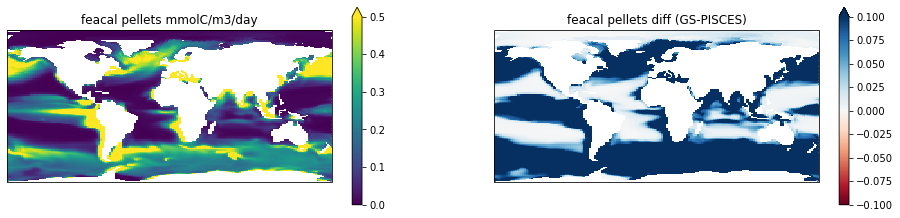

In [20]:
# Defecation
WC = ((1-betaV)*protein) + ((1-betaH)*carbo)
WN = (1-betaV)*protein/thetaV
poop= diad['POOZ2'].isel(deptht=0)*86400*1000
diffp= WC-poop

fig= plt.figure(figsize=(16,8))
fig.patch.set_facecolor('xkcd:white')
ax0= plt.subplot(2,2,1, projection= ccrs.PlateCarree())
WC.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.5, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title(r'feacal pellets mmolC/m3/day')

ax0= plt.subplot(2,2,2, projection= ccrs.PlateCarree())
diffp.plot(y='nav_lat', x='nav_lon', vmin=-.1, vmax= .1, cmap='RdBu', transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('feacal pellets diff (GS-PISCES)')

Text(0.5, 1.0, 'Excretion from PISCES mmol/m3/day')

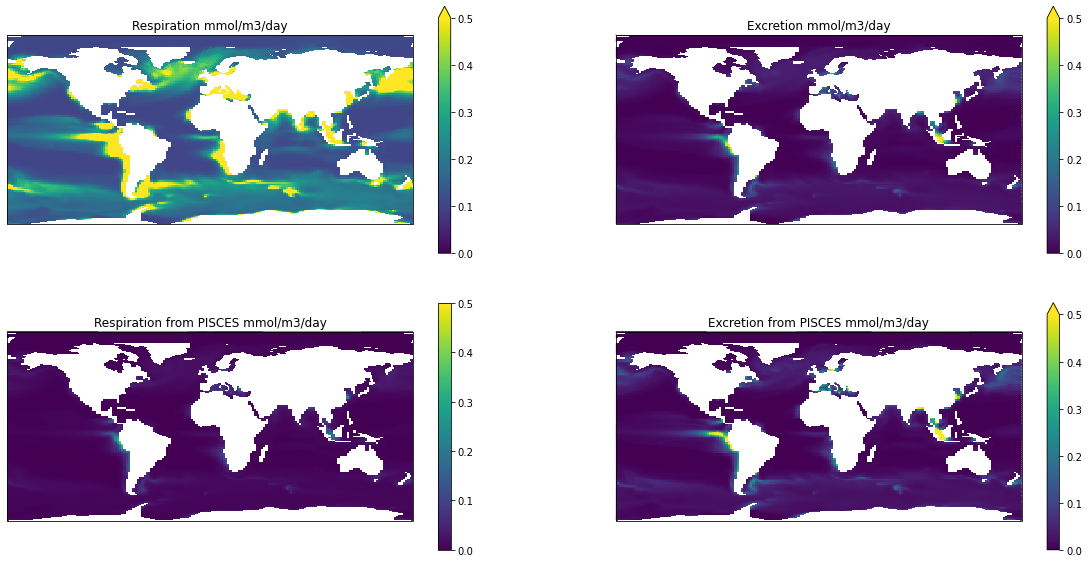

In [15]:
ex=diad['EXCZ2'].isel(deptht=0)*86400*1000
respir=diad['RESPIRC2'].isel(deptht=0)*86400*1000

diffE= E-ex
diffR= R-respir

fig= plt.figure(figsize=(20,10))
fig.patch.set_facecolor('xkcd:white')
ax0= plt.subplot(2,2,1, projection= ccrs.PlateCarree())
R.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.5, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title(r'Respiration mmol/m3/day')

ax0= plt.subplot(2,2,2, projection= ccrs.PlateCarree())
E.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.5, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('Excretion mmol/m3/day')

ax0= plt.subplot(2,2,3, projection= ccrs.PlateCarree())
respir.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.5, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title(r'Respiration from PISCES mmol/m3/day')

ax0= plt.subplot(2,2,4, projection= ccrs.PlateCarree())
ex.plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.5, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('Excretion from PISCES mmol/m3/day')

Text(0.5, 1.0, 'diff Excretion (GE-PISCES)')

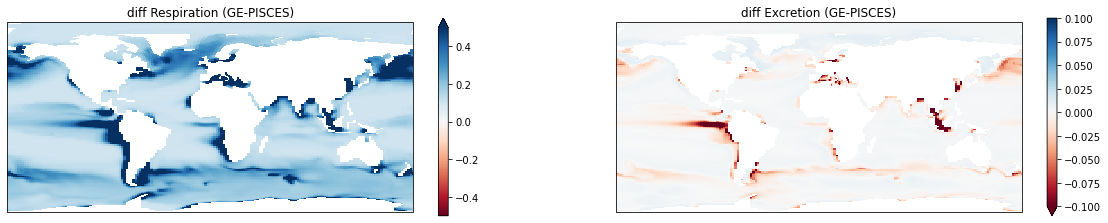

In [17]:
fig= plt.figure(figsize=(20,8))
fig.patch.set_facecolor('xkcd:white')
ax0= plt.subplot(2,2,1, projection= ccrs.PlateCarree())
diffR.plot(y='nav_lat', x='nav_lon', vmin=-0.5, vmax= 0.5, cmap='RdBu', transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title(r'diff Respiration (GE-PISCES)')

ax0= plt.subplot(2,2,2, projection= ccrs.PlateCarree())
diffE.plot(y='nav_lat', x='nav_lon', vmin=-0.1, vmax= 0.1, cmap='RdBu',transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('diff Excretion (GE-PISCES)')